In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras   # J: this is the machine learning
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py   # J: this is for the type of input data files
import os 
from clr_callback import *   # J: I had to download a py file from Github for this
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# Required python scripts and files 
X_maxmean_new = np.load('X_maxmean_new.npy')       # J: list of mean and max for the 43 variables? But how is it produced?
Y_maxmean_new = np.load('Y_maxmean_new.npy')
X_maxmean_tao = np.load('X_maxmean_tao.npy')       # J: list of mean and max for the 43 variables? But how is it produced?
Y_maxmean_tao = np.load('Y_maxmean_tao.npy')

In [5]:
# Parameters ============================================================================
# Path to h5 file
#name = './../../../../../data/hongtao/inputs_2021-02-05/variables_tt_rmu_padded.h5'
name_new = '/data/jchishol/variables_ttbar_parton_ejets.h5'    # J: this is my input file, although it may be made wrong
name_tao = '/data/jchishol/Tao_Data/variables_tt_rmu_padded.h5'   # J: this is his input file
# prediction save file
pred_name = 'preds.npy'
pred_name_tao = 'preds_tao.npy'
# true save file
true_name = 'true.npy'
true_name_tao = 'true_tao.npy'
# Predictions are saved in a (#samples)x20 array, with 
# ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
# ordering
# =======================================================================================

In [6]:
#name0 = os.path.basename(name) # J: do we really need name0?
#name0 = re.sub('\.h5$', '', name0)
dataset_new = h5py.File(name_new,'r')
dataset_tao = h5py.File(name_tao,'r')
# ['j1_pt', 'j1_eta', 'j1_phi', 'j1_x', 'j1_y', 'j1_z', 'j1_m', 'j1_e', 'j1_DL1r', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_x', 'j2_y', 'j2_z', 'j2_m', 'j2_e', 'j2_DL1r', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_x', 'j3_y', 'j3_z', 'j3_m', 'j3_e', 'j3_DL1r', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_x', 'j4_y', 'j4_z', 'j4_m', 'j4_e', 'j4_DL1r', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_x', 'j5_y', 'j5_z', 'j5_m', 'j5_e', 'j5_DL1r', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_x', 'j6_y', 'j6_z', 'j6_m', 'j6_e', 'j6_DL1r', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_x', 'lep_y', 'lep_z', 'lep_e', 'met_met', 'met_phi']
size = np.array(dataset_new.get('th_pt')).size
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']

In [7]:
#J:Do we need all these keys? Where are they used? -- oh yes in other codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset_new.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset_new.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset_new.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset_new.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset_new.keys()))
print(phi_keys)

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  size

['j1_phi', 'j2_phi', 'j3_phi', 'j4_phi', 'j5_phi', 'j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wh_phi', 'wl_phi']


In [15]:
import normalize  # J: import this after phi keys are defined (maybe now it will work in python)
import shape_timesteps
importlib.reload(normalize)
importlib.reload(shape_timesteps)

# J: added this because it needs to be defined
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))

# Testing what the inputs look like:

<ipython-input-11-8a10a367465b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(var)


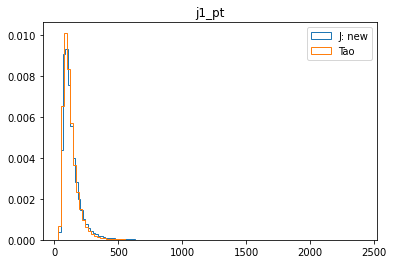

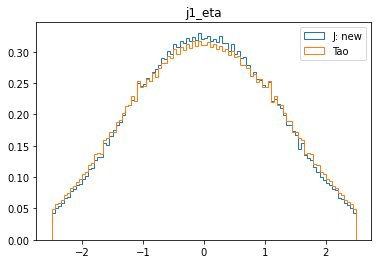

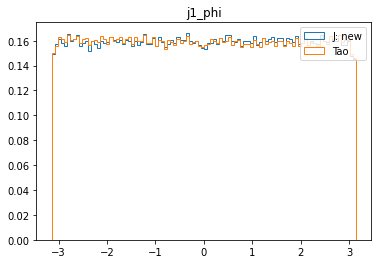

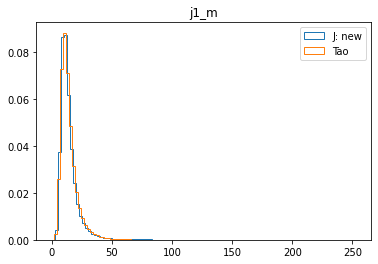

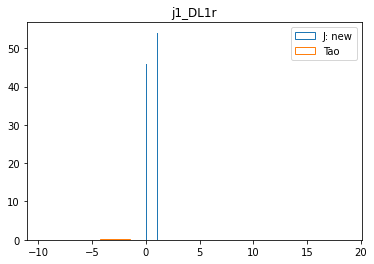

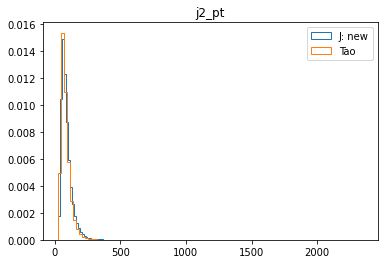

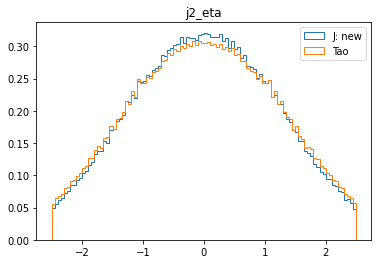

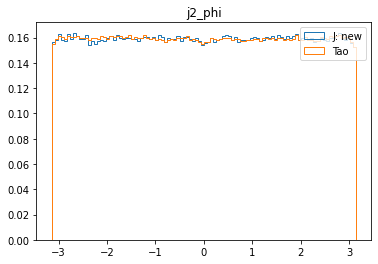

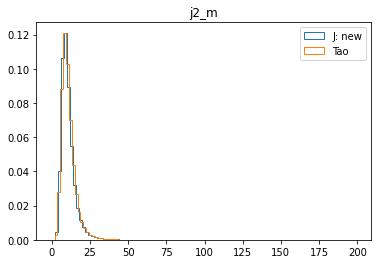

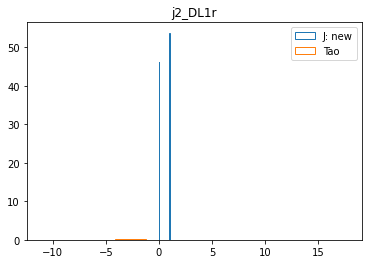

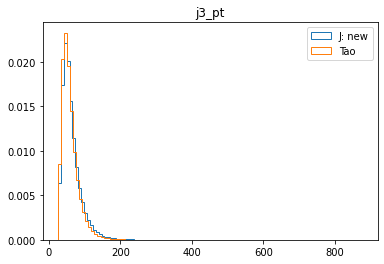

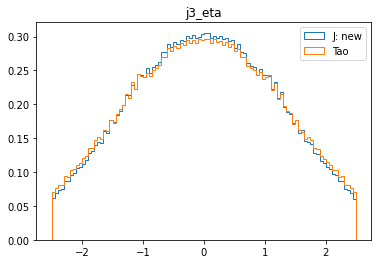

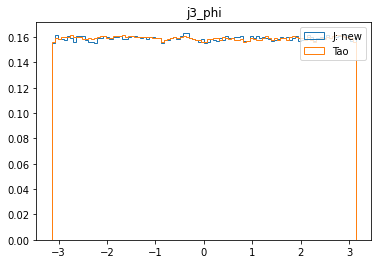

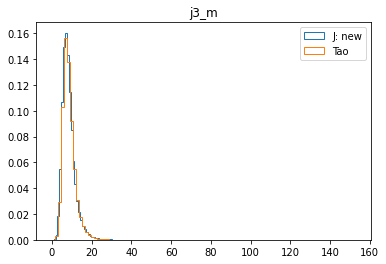

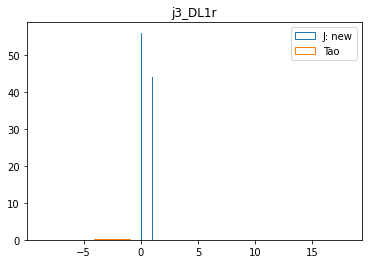

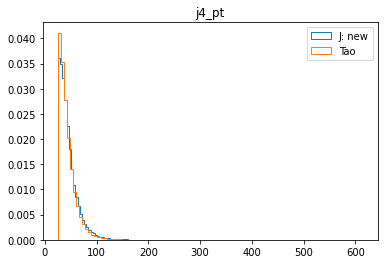

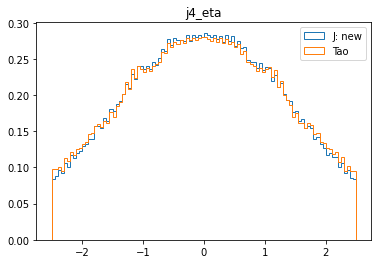

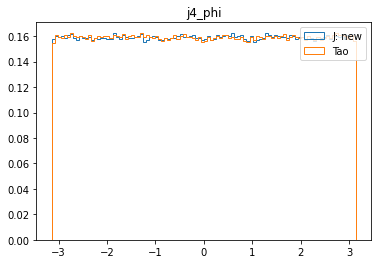

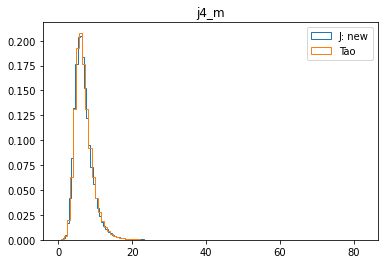

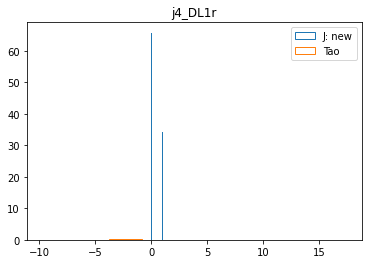

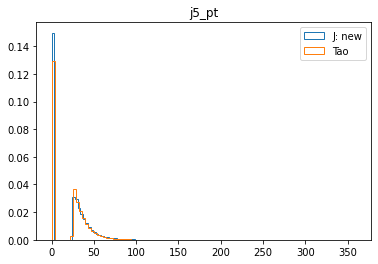

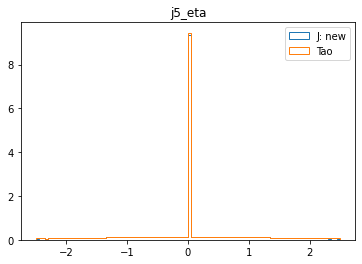

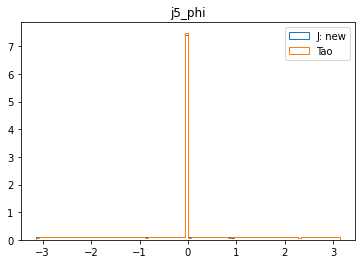

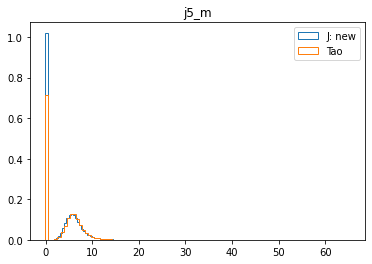

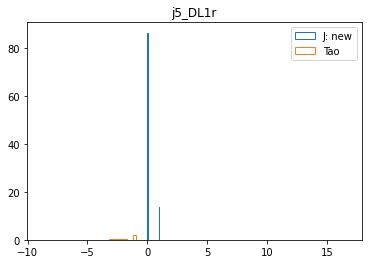

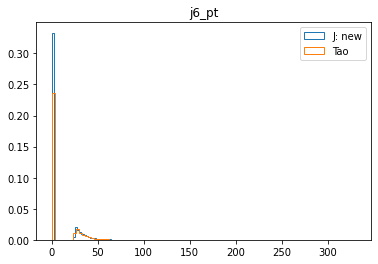

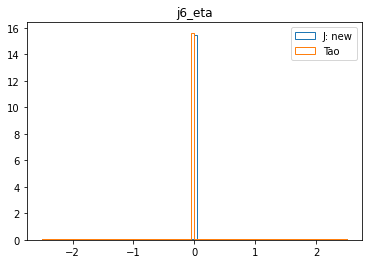

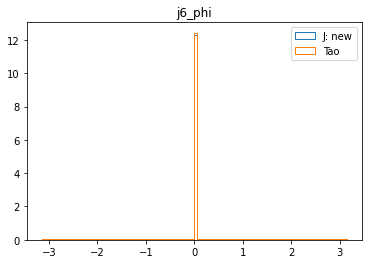

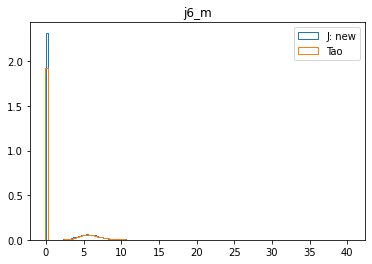

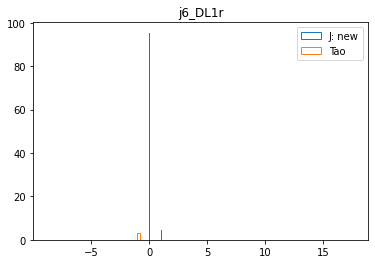

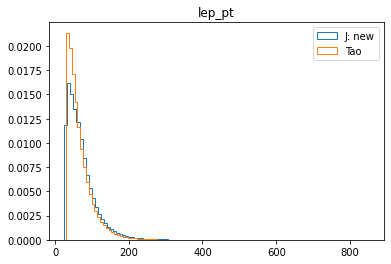

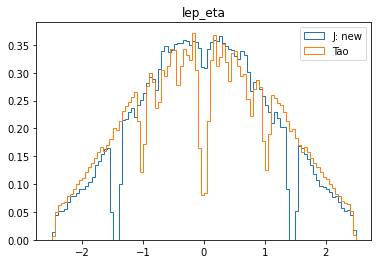

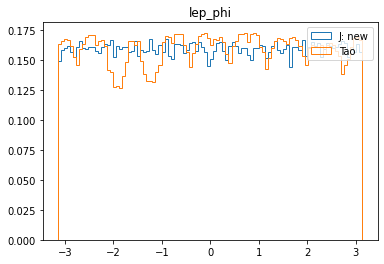

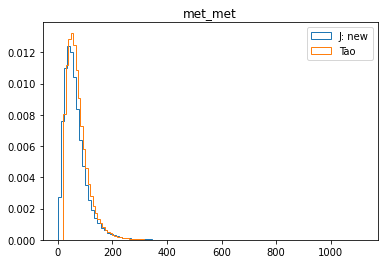

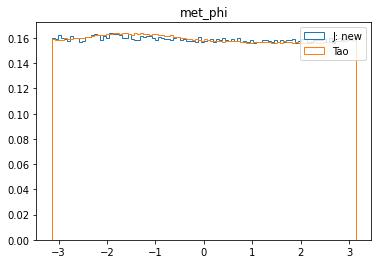

In [11]:
for var in X_keys:
    plt.figure(var)
    plt.title(var)
    plt.hist(np.array(dataset_new.get(var)),bins=100,density=True,histtype='step')
    plt.hist(np.array(dataset_tao.get(var)),bins=100,density=True,histtype='step')
    plt.legend(['J: new','Tao'])

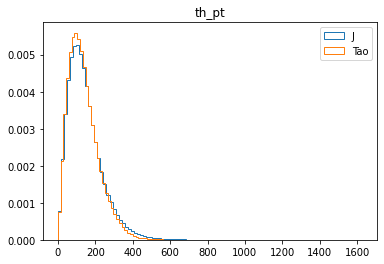

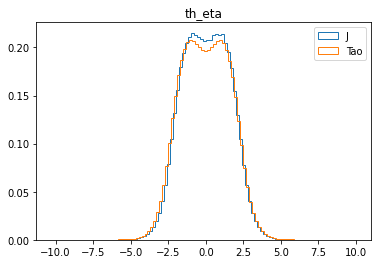

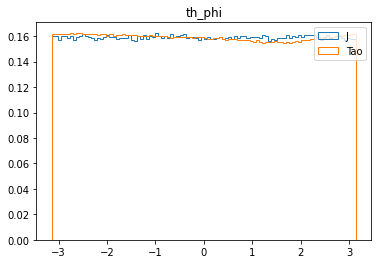

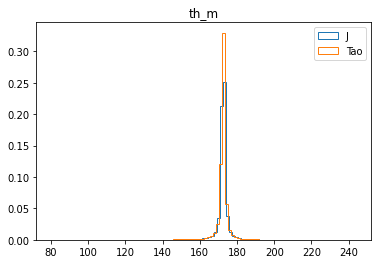

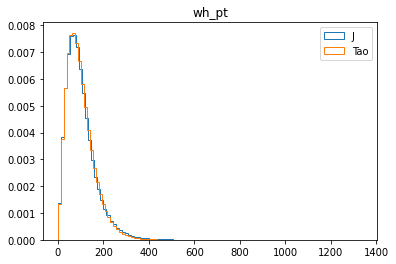

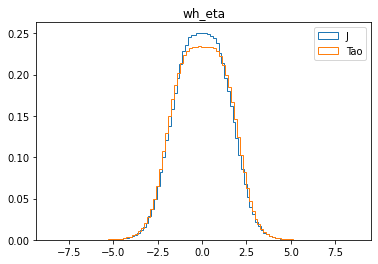

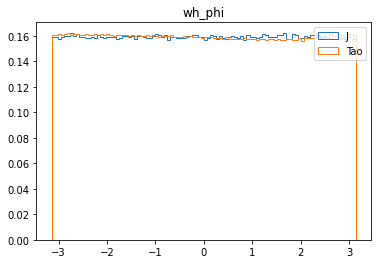

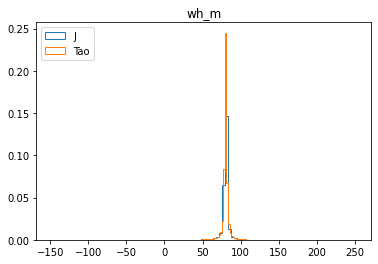

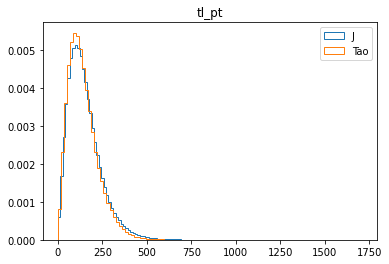

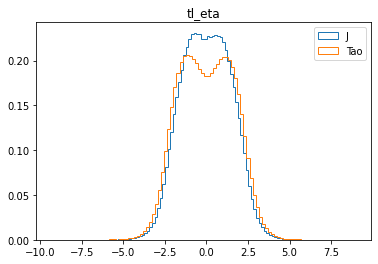

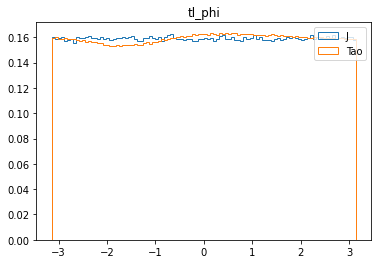

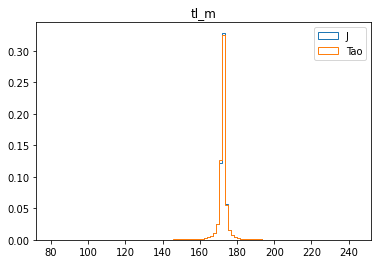

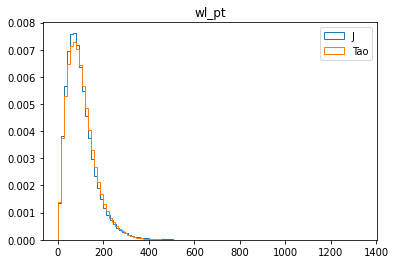

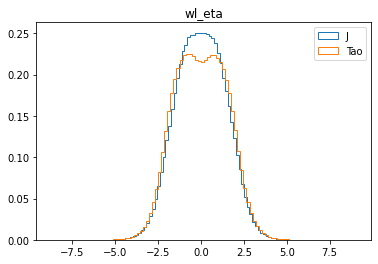

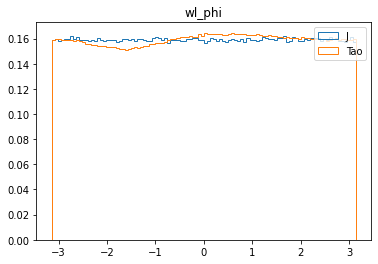

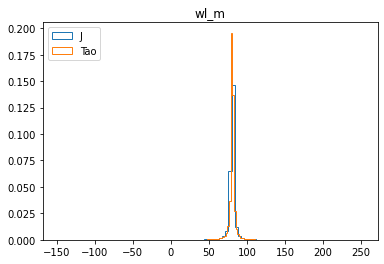

In [16]:
for var in Y_keys:
    if var=='th_eta':
        plt.figure(var)
        plt.title(var)
        plt.hist(np.array(dataset_new.get(var)),bins=100,density=True,range=(-10,10),histtype='step')
        plt.hist(np.array(dataset_tao.get(var)),bins=100,density=True,histtype='step')
        plt.legend(['J','Tao'])
    else:
        plt.figure(var)
        plt.title(var)
        plt.hist(np.array(dataset_new.get(var)),bins=100,density=True,histtype='step')
        plt.hist(np.array(dataset_tao.get(var)),bins=100,density=True,histtype='step')
        plt.legend(['J','Tao'])

# Back to Scaling:

In [17]:
# J: these lines pre-process the data (i.e. scaling, getting px, py, etc.)

dataset = dataset_new
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean_new)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean_new)

dataset = dataset_tao
Scaler = normalize.Scale_variables()
X_total_tao, X_names_tao = Scaler.scale_arrays(X_keys, X_maxmean_tao)
Y_total_tao, Y_names_tao = Scaler.scale_arrays(Y_keys, Y_maxmean_tao)

# J: I want to see what's here
print ('X names:')
print (X_names)
print ('Y names:')
print (Y_names)

X names:
['j1_ptbox', 'j1_px', 'j1_py', 'j1_eta', 'j1_m', 'j1_DL1r', 'j2_ptbox', 'j2_px', 'j2_py', 'j2_eta', 'j2_m', 'j2_DL1r', 'j3_ptbox', 'j3_px', 'j3_py', 'j3_eta', 'j3_m', 'j3_DL1r', 'j4_ptbox', 'j4_px', 'j4_py', 'j4_eta', 'j4_m', 'j4_DL1r', 'j5_ptbox', 'j5_px', 'j5_py', 'j5_eta', 'j5_m', 'j5_DL1r', 'j6_ptbox', 'j6_px', 'j6_py', 'j6_eta', 'j6_m', 'j6_DL1r', 'lep_ptbox', 'lep_px', 'lep_py', 'lep_eta', 'met_met', 'met_phi-sin', 'met_phi-cos']
Y names:
['th_ptbox', 'th_px', 'th_py', 'th_eta', 'th_m', 'wh_ptbox', 'wh_px', 'wh_py', 'wh_eta', 'wh_m', 'tl_ptbox', 'tl_px', 'tl_py', 'tl_eta', 'tl_m', 'wl_ptbox', 'wl_px', 'wl_py', 'wl_eta', 'wl_m']


# Testing Scaled Inputs:

<ipython-input-18-f12c10fc8046>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(X_names[i])


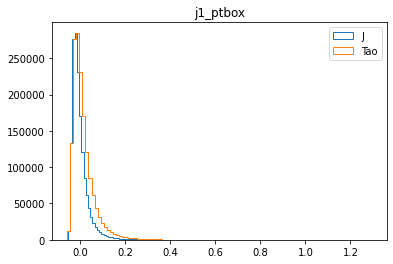

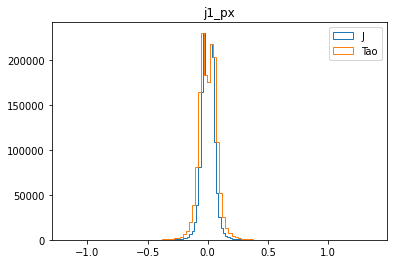

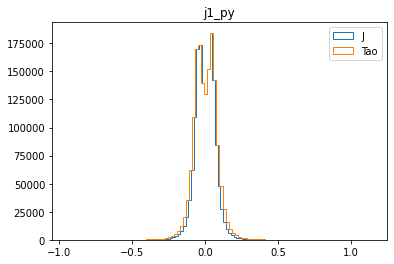

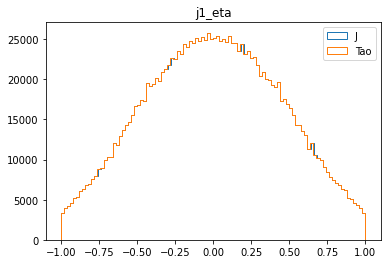

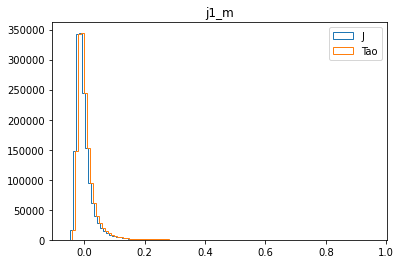

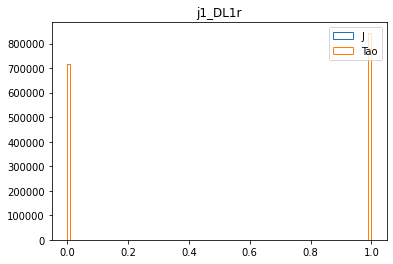

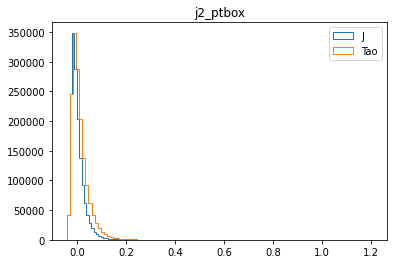

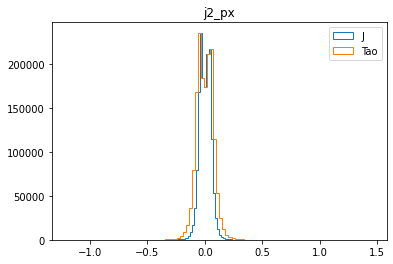

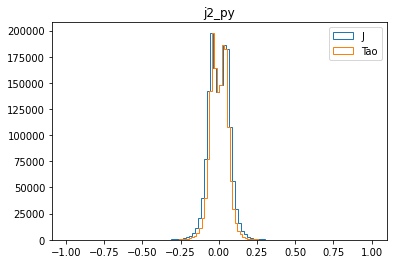

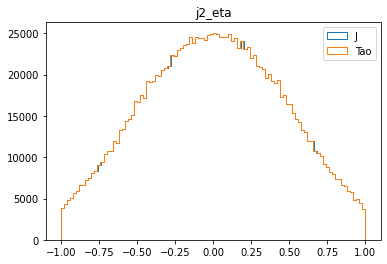

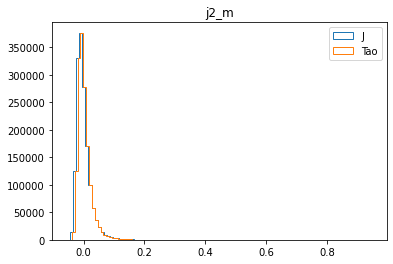

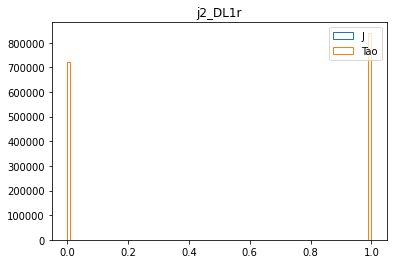

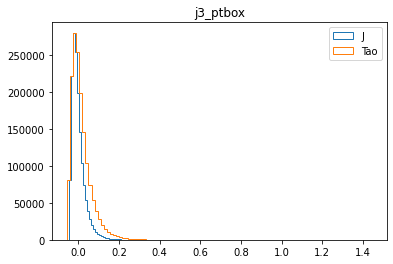

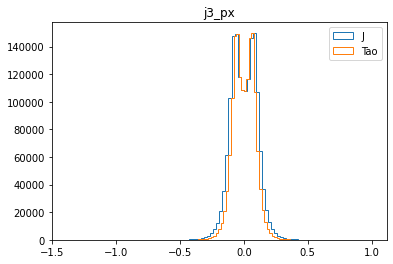

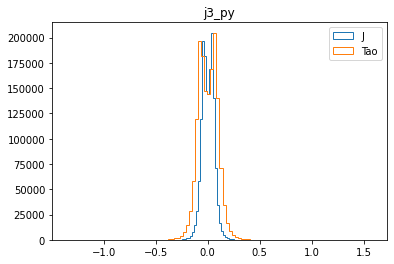

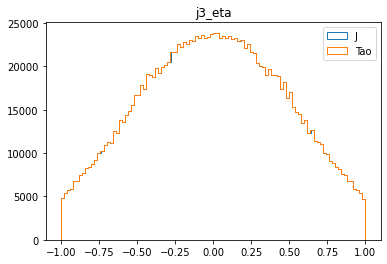

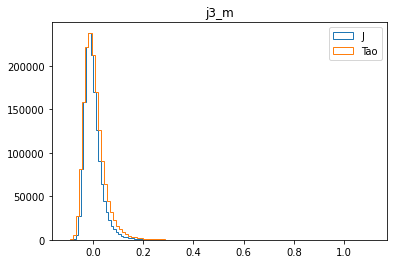

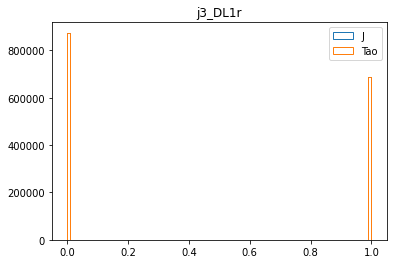

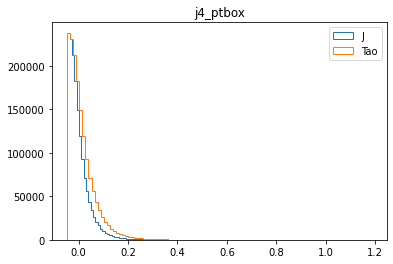

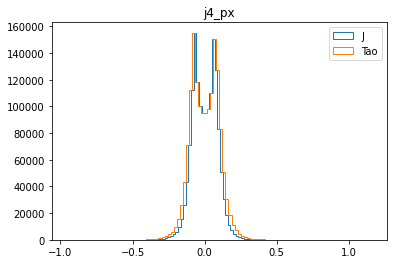

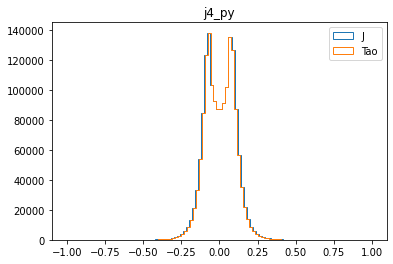

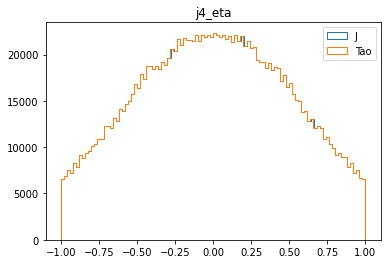

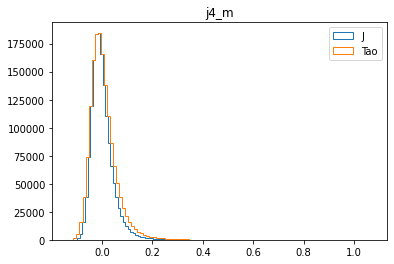

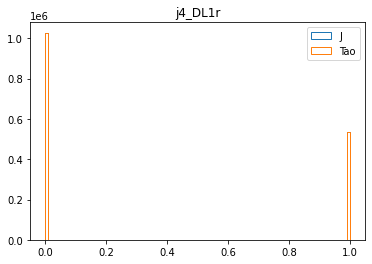

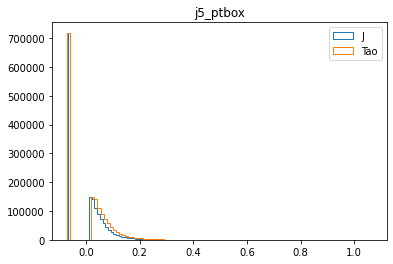

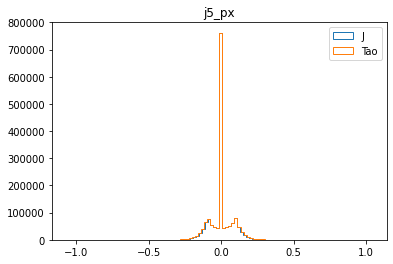

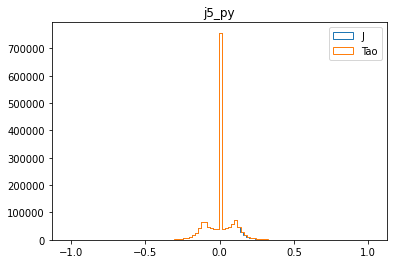

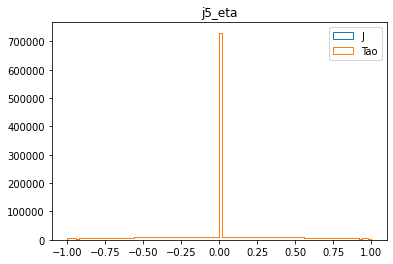

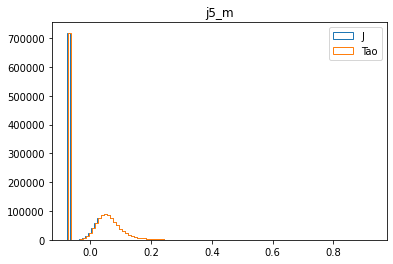

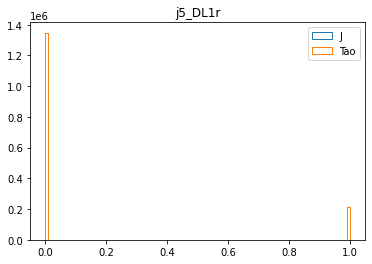

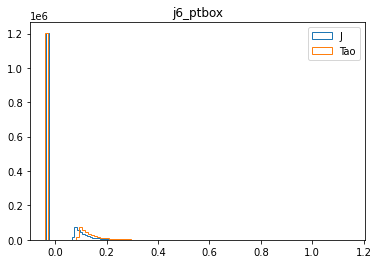

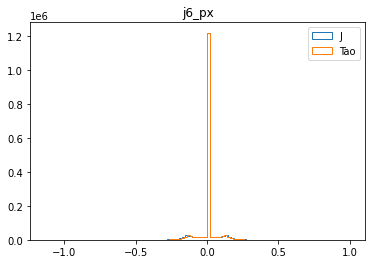

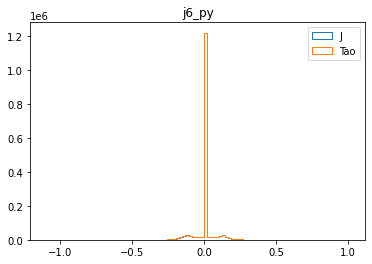

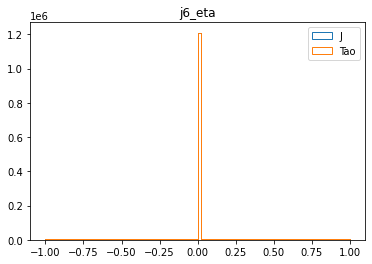

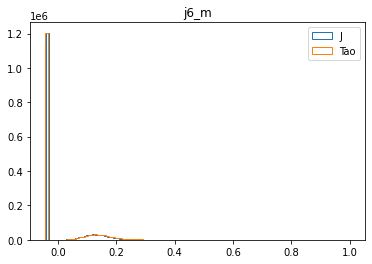

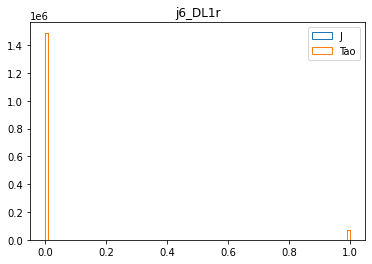

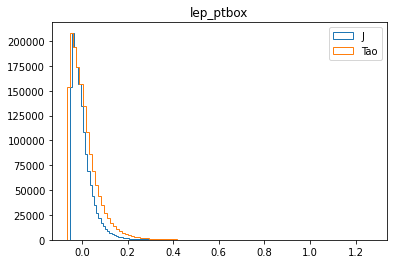

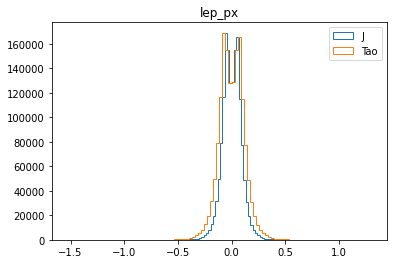

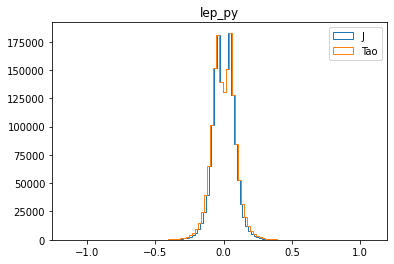

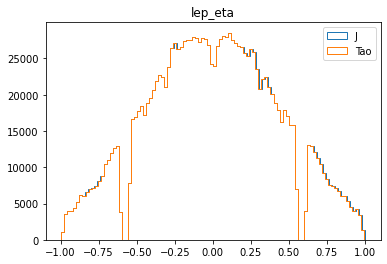

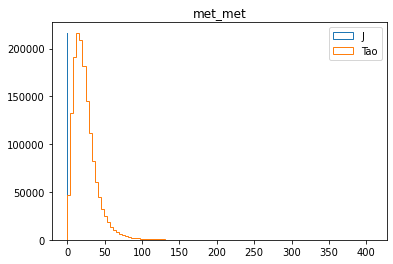

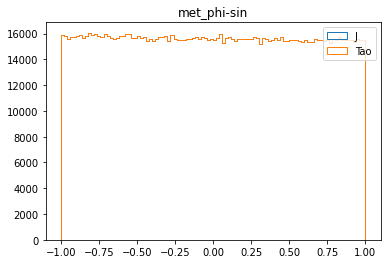

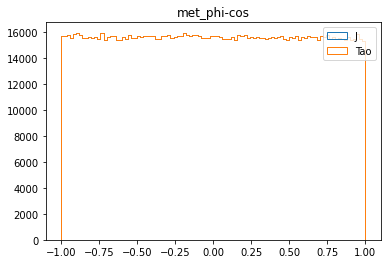

In [18]:
for i in range(len(X_total[0])):
    plt.figure(X_names[i])
    plt.title(X_names[i])
    plt.hist(X_total[:,i],bins=100,histtype='step')
    plt.hist(X_total_tao[:,i],bins=100,histtype='step')
    plt.legend(['J','Tao'])

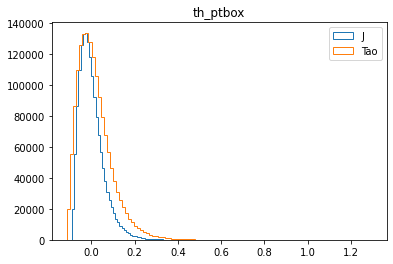

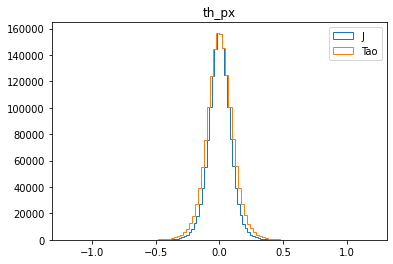

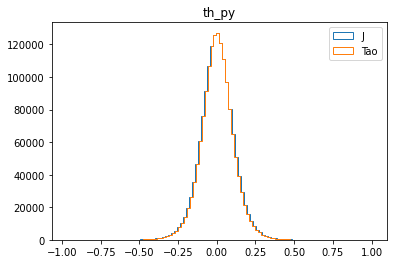

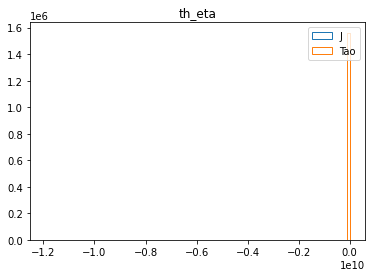

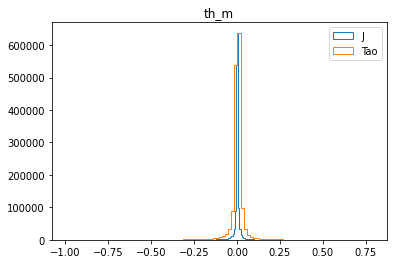

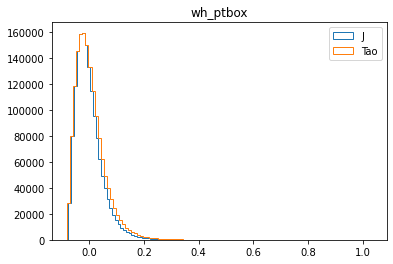

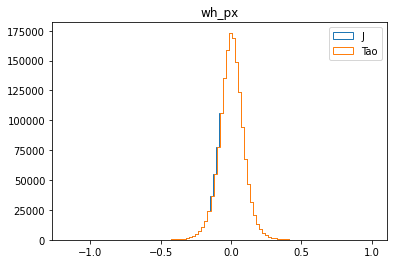

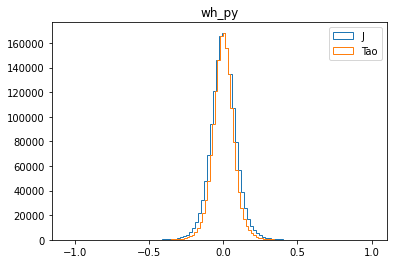

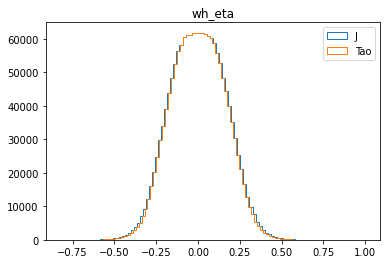

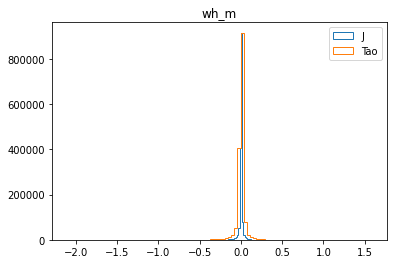

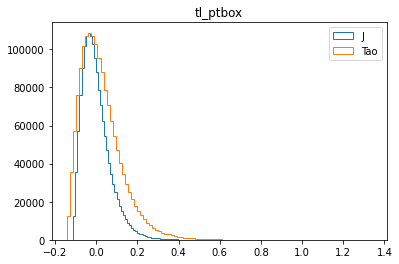

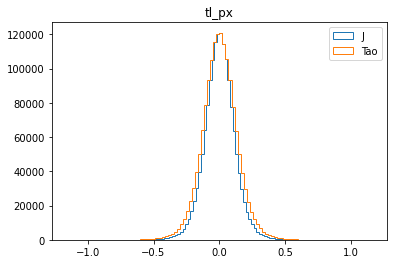

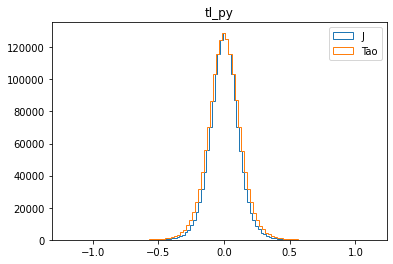

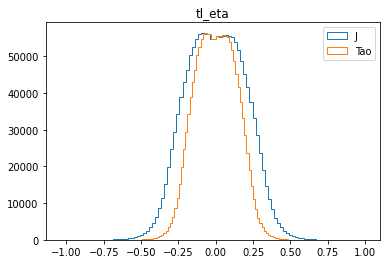

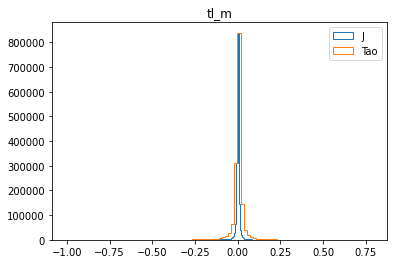

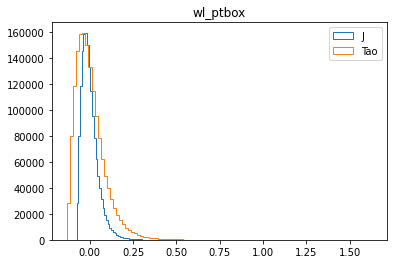

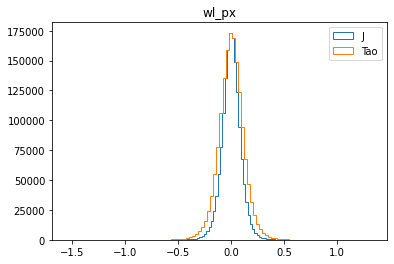

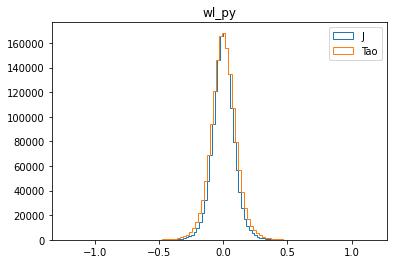

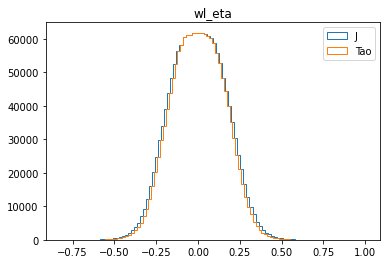

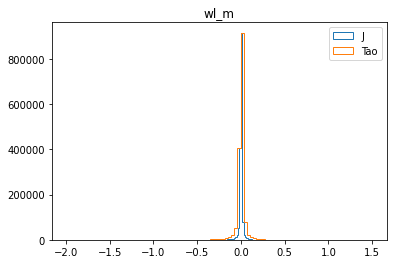

In [19]:
for i in range(len(Y_total[0])):  
    plt.figure(Y_names[i])
    plt.title(Y_names[i])
    plt.hist(Y_total[:,i],bins=100,histtype='step')
    plt.hist(Y_total_tao[:,i],bins=100,histtype='step')
    plt.legend(['J','Tao'])

# Back to Predicting:

In [20]:
# Create X and test array
split = int(np.floor(0.95*crop0)) 
split = 0 

# J: splitting truth data into some for training ML and some for testing ML
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

# J: no idea what this does, maybe splits jets and other variables???
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# J: again, splitting reco data into some for training and some for testing (this time by jets and by other)
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]
print(testX_jets.shape, testX_other.shape, testY.shape)

(1562065, 6, 6) (1562065, 7) (1562065, 20)


In [22]:
if testX_jets.shape[0] > 0: 
    other_bins = np.linspace(-1, 1, 40)
    phi_bins = np.linspace(-1, 1, 40)
    pt_bins = np.linspace(-1, 1, 40)
    Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

    #model = keras.models.load_model('./../runs/12-3-clean.keras', custom_objects={'loss_fc':loss_fc})
    model = keras.models.load_model('./model.keras', custom_objects={'loss_fc':loss_fc})  # J: maybe this model idk

    # J: making a prediction, but I don't feel like we've used the training data at all ...
    # J: this doesn't even seem to be used later so idk the point
    predictions_unscaled = model.predict([testX_jets, testX_other])
    true_unscaled = testY 

    # J: okay this ones seems to use both training and testing data?
    total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
    #Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)  # J: didn't we already do this?

    # J: I think this undoes the scaling we did in the pre-processing earlier
    predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean_new)[split:,:]
    true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean_new)[split:,:]

    # J: save predictions and truth
    np.save(pred_name, predictions_origscale)
    np.save(true_name, true_origscale)
else:
    print('skip')
dataset.close()

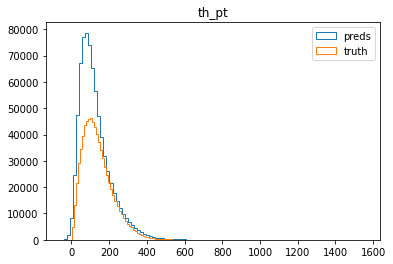

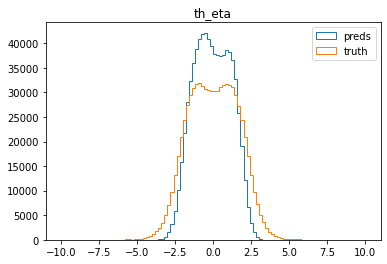

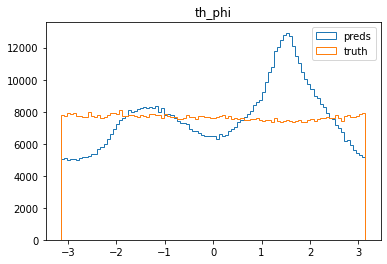

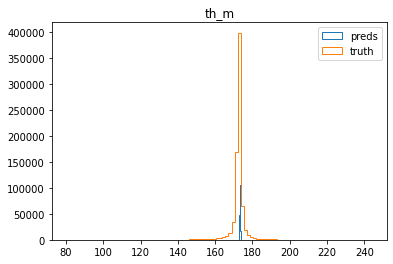

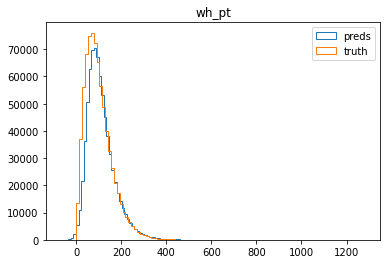

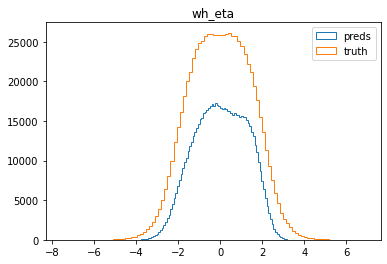

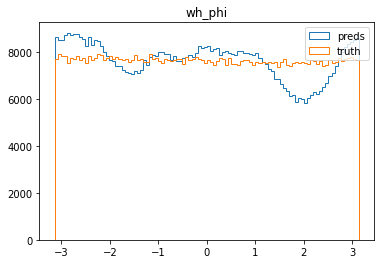

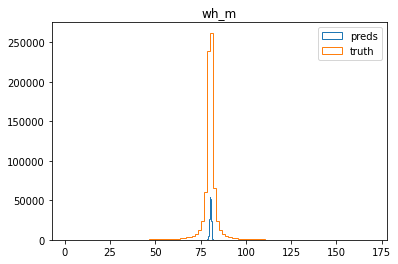

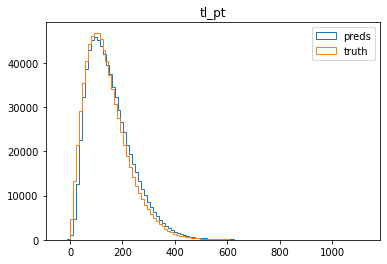

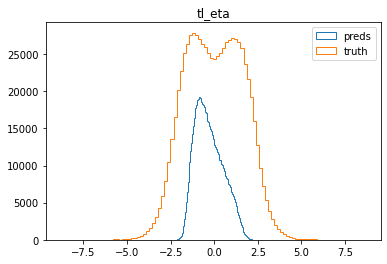

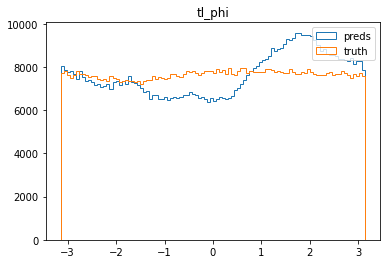

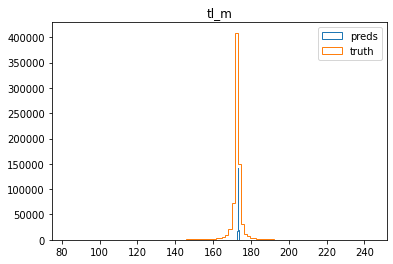

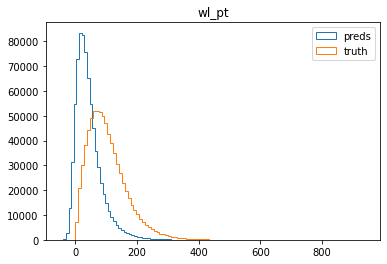

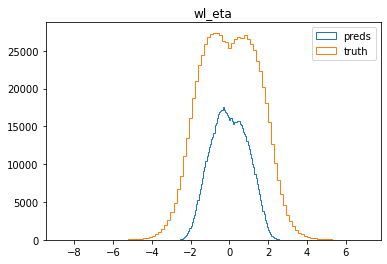

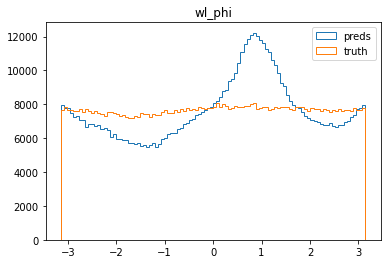

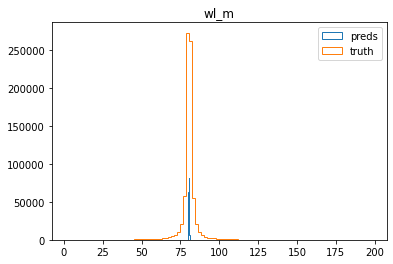

In [35]:
preds = np.load('preds.npy')
truth = np.load('true.npy')

for i in range(len(truth.T)):
    if i==1:
        plt.figure(str(i))
        plt.title(Y_keys[i])
        plt.hist(preds[:,i],bins=100,range=(-10,10),histtype='step')
        plt.hist(truth[:,i],bins=100,range=(-10,10),histtype='step')
        plt.legend(['preds','truth'])
    else:
        plt.figure(str(i))
        plt.title(Y_keys[i])
        plt.hist(preds[:,i],bins=100,histtype='step')
        plt.hist(truth[:,i],bins=100,histtype='step')
        plt.legend(['preds','truth'])